## Import libraries and dataset
---

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string 
from sklearn.metrics import accuracy_score 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

In [62]:
# set display option to show more rows
pd.set_option('display.max_colwidth',3000)

In [63]:
# import dataest
df1 = pd.read_csv('../data/df1.csv')
df2 = pd.read_csv('../data/df2.csv')

C:\Users\hoven\AppData\Local\Temp\ipykernel_22540\2977060385.py:2: DtypeWarning: Columns (4,7,8,12,22,23,28,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('../data/df1.csv')


## Functions
---

In [64]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    """
    Function to show word clouds, without stop words
    """
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [65]:
# code is referenced from: https://stackoverflow.com/questions/58623226/regex-to-search-and-replace-emojis-in-openrefine

def remove_symbols(text):
    """
    Remove symbols from text
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [66]:
def clean_text(text):
    """
    Remove brackets, puncutation, words with numbers and convert text to lowercase
    """
    text = str(text).lower()
    text = re.sub('r/', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'[^\w\s]','', text) 
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('"', '')
    text = re.sub(r'[^a-zA-Z0-9=]', ' ',text)
    return text

In [67]:
def epoch_to_date(df):
    """
    Create a new column that converts convert epoch to datetime
    """
    df['created_date']= (pd.to_datetime(df['created_utc'],unit='s'))
    return df['created_date']

## Data Cleaning 
---

In [68]:
# examine the columns
df1.columns

Index(['all_awardings', 'allow_live_comments', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_is_blocked', 'author_patreon_flair',
       'author_premium', 'awarders', 'banned_by', 'call_to_action',
       'can_mod_post', 'category', 'contest_mode', 'created_utc',
       'crosspost_parent', 'crosspost_parent_list', 'distinguished', 'domain',
       'edited', 'event_end', 'event_is_live', 'event_start', 'full_link',
       'gilded', 'gildings', 'id', 'is_created_from_ads_ui',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_template_id', 'link_flair_text', 'link_flair_text_color',
       'link_flair_type', 

We are only interested in several columns  
* **subreddit** - Where the content is posted to
* **title** - Title of the post
* **author** - Creator of the post
* **selftext** - Text body of the post, if any
* **created_utc** - Date of post created
* **id** - Id number of the post

In [69]:
# select columns
col = ['author', 'subreddit', 'title', 'selftext', 'created_utc', 'id']

In [70]:
df1 = df1[col]
df2 = df2[col]

In [71]:
# examine r/Stoicism
print(df1.shape)
df1.sample(5)

(9987, 6)


,author,subreddit,title,selftext,created_utc,id
9367,stoic_Ram,Stoicism,How to not let caution slip into phobia?,"This might seem like a minor problem, but I cannot function properly and I spend all of my time thinking about this.\n\nThe problem: \n\nI'm being hypervigilant about avoiding stuffs that MAY BE harmful to me.\n\nFor instance, ever since I learned plastics can leach harmful substances when it comes in contact with hot surface, I removed almost every plastic from my kitchen, even then, I supervise everytime my mom is cooking( thrice a day), to make sure she does not take the knife with plastic handle anywhere near the stove. It makes me very uncomfortable (anxious) if I find it anywhere near the stove. I spend entire day thinking about it. \n\nThe real problem is I spend a lot of time debating with myself, if I should tell her to get a wooden handle knife, or if telling her to get a wooden handle knife will make me look like a stupid. \n\nWhen I try to apply stoic ideas here, I believe that telling her to get a wooden handle knife is within my control but I also feel like it is driven by my irrational fear( as the probability of the knife getting in contact with my food is very less and even if it happens the dose is going to be very less to be of concern) but I also think it would be against nature to not act towards self preservation. \n\nThis is just one example, there are limitless stuffs I think about every day which sucks time and energy from me ( I completely stopped eating anything with sugar, junk foods, I have not touched alcohol, started using shampoo with least chemicals etc.)\nThough sometimes this EXTREME PHOBIA ( bordering OCD) seems to help me avoid being addicted to bad stuffs, it takes away A LOT of time, energy and peace of mind. ( I'm unemployed and should be spending my time studying to make myself employable but I spend all my time thinking about these stuffs ) \n\nI wish I was driven by rationality, not fear to avoid stuffs that are harmful to me. \n\nAnd as for attending therapy, \n1. I live in a rural town in India, I'd have to travel at least a hundred kilometres by bus to find a decent therapist.\n\n2. My parents do not believe in phobia/ OCD or other such mental illnesses and I'm unemployed so I cannot afford therapy without their help.",1622990416,ntn7tx
4041,shittyfuckdick,Stoicism,How to Cope With Going Deaf?,"Last month I had a really bad flu. I woke up on morning and was completely deaf. \n\nThe docs put on my steroids and antibiotics which brought back a lot of my hearing, but I am still left with permanent hearing loss and very bad tinnitus. Really the worse part is the tinnitus. It’s loud and is there everyday to remind me of my new disability. \n\nI also can’t do things like use headphones or go to loud places anymore in fear of making it worse. I’m only 26 and I now have a lot of my life taken away from the something the seemingly happened out of nowhere. I was already very depressed before this happened, and this just feels like kicking my while I’m down. \n\nI know stoicism teaches to only focus on what we can control. But I’m having a hard time adapting to this, especially with the tinnitus there ruining every second of my day.",1640197037,rmb7ii
9561,ellixit,Stoicism,Help with Loneliness,"After first reading Meditations nearly three years ago, I made the choice to begin practicing Stoicism in my life. It has helped me through a great many things in my life since then, from getting distressing news about the well being of those close to me to being more grateful in my everyday life. Thanks to Stoicism, I made it through the majority of 2020 relatively emotionally unscathed.\n\nHowever, in the past few months I have been experiencing symptoms typically associated with depression, and although I have not been officially diagnosed, I believe it is the most likely cause of my symptoms. I have been a fairly devout Stoic up to this point in my life, but none of the wisdom and teach

In [72]:
# examine r/Buddhism
print(df2.shape)
df2.sample(5)

(9992, 6)


,author,subreddit,title,selftext,created_utc,id
9003,hhh6h,Buddhism,"Prayers to ""God"" in the past have been answered. How do I make sense of this?",I ask this because Buddhism rejects the existence of the God of Abrahamic faiths. I am not alone in having experienced this.,1642885982,saca8y
7348,3-pointz,Buddhism,How should Who am I question be answered?,I was reading that our attachments to things are the cause of our misery in this way we should become detached from people objects external stimuli and even what we call the body we should try to escape the “l am” statement because this leads us to attachment toward ourself which can become unhealthy but when someone ask me Who am I? how should this question be answered if im detaching from the “I”,1645243213,sw0whc
509,SinofTruth11,Buddhism,What do you speculate might happen if I showed Moving levitation Siddhi?,I can't do it yet but I have been thinking on it and it wouldn't be wise to show the materialistic superficial masses just yet,1655269928,vcmuo7
5153,WhereIsTheBodyJon,Buddhism,"Truly, the second noble truth is a truth","I have intellectually known theta the second noble truth, one of the four noble truths was very correct I think hat desire/attachment or craving brings suffering due to it being ultimately impermanent, but emotionally and spiritually I have not truly incorporated this concept\nBut today at school, during lunch I bring my back back full of my papers and materials and when I go and get lunch it’s left on my cafeteria seat, this has brought me worry as to if it were to be stolen it would be devastating for me\n\nBut I left it in a counselors office accidentally so that I could do some work quietly but I forgot it, and i forgot about the backpack until my last period and then I took it from the office\n\nImmediately after that at some time at home or school, I realized that some gigantic mental weight was lifted from me during that time of not having my backpack allowing me some form of peace with my belongings(or nonexistent ones) \n\nit was so pleasant",1648607840,trwbhu
9976,buddhadharmapractice,Buddhism,12 Vows of Medicine Buddha - #1,"&gt;I vow that my body shall shine as beams of brilliant light on this infinite and boundless world, showering on all beings, getting rid of the ignorance and worries with my teachings. \n\n&gt;May all beings be like me, with a perfect status and character, upright mind and soul, and finally attaining enlightenment like the Buddha.",1641518914,rxuv0f


### Check for missing values

In [73]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9987 entries, 0 to 9986
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       9987 non-null   object
 1   subreddit    9987 non-null   object
 2   title        9987 non-null   object
 3   selftext     9183 non-null   object
 4   created_utc  9987 non-null   int64 
 5   id           9987 non-null   object
dtypes: int64(1), object(5)
memory usage: 468.3+ KB


In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       9992 non-null   object
 1   subreddit    9992 non-null   object
 2   title        9992 non-null   object
 3   selftext     6505 non-null   object
 4   created_utc  9992 non-null   int64 
 5   id           9992 non-null   object
dtypes: int64(1), object(5)
memory usage: 468.5+ KB


On both dataframe, missing values are observed on the `selftext` column. It is possible for a post to contain the title only. The `selftext` column may provide information of each subreddit and it will not be dropped despite the amount of missing values. Instead, it will be merged with `title` later on.

### Check for duplicate

In [75]:
df1.apply(lambda x:sum(x.duplicated()))

author         4046
subreddit      9986
title           268
selftext       1304
created_utc       5
id                0
dtype: int64

In [76]:
df2.apply(lambda x:sum(x.duplicated()))

author         5541
subreddit      9991
title           266
selftext       4600
created_utc       3
id                0
dtype: int64

* Duplicate in `author`,  `subreddit` will be ignored
* Duplicates in `title` could mean multiple post. We will use `author` to determine if the duplicated post comes from the same person
* Duplicates in `created_utc` means posts created on the same time. It may be possible this may happen. As long as `title` and `author` is different, it can be assumed it is a unique post

In [77]:
# determine the number of duplicates  between author and title
len(df1[df1.duplicated(subset=['title','author'])])

170

In [78]:
len(df2[df2.duplicated(subset=['title','author'])])

194

There are 170 and 194 duplicated posts in r/Stocism and r/Buddhism respectively which are made by the same author. We will assume these are duplicated post and will be dropped.

In [79]:
# drop duplicate for r/Stoicism
df1.drop_duplicates(subset=['title', 'author'], inplace=True)

In [80]:
# drop duplicate for r/Buddhism
df2.drop_duplicates(subset=['title', 'author'], inplace=True)

In [81]:
# reverify duplicates
df1.apply(lambda x:sum(x.duplicated()))

author         3876
subreddit      9816
title            98
selftext       1161
created_utc       3
id                0
dtype: int64

In [82]:
df2.apply(lambda x:sum(x.duplicated()))

author         5347
subreddit      9797
title            72
selftext       4423
created_utc       1
id                0
dtype: int64

In [83]:
# examine first 5 duplicate rows for r/Stoicism
df1[df1['title'].duplicated(keep=False)].head()

,author,subreddit,title,selftext,created_utc,id
12,AutoModerator,Stoicism,Agora: Weekly self-promotion thread,"Please post any content that falls under self-promotion as a first-level comment in this thread, and don't reference it anywhere else on the subreddit.\n\nPosted items must be relevant to Stoicism.\n\nPlease don't post the same item over and over again - the limit is one author/blog/youtube channel per week.\n\nEven if you liked something you saw in this thread very much, please don't repost it, and don't promote it in other threads.",1655941508,viiyp1
86,LawAgitated913,Stoicism,We don’t have power over our emotions but we do have power over how we respond to them.,"\nThe response is quick and of the nature of identification with the thought however observation is what works with regards to emotions. Mindfulness is required to sort the difference between the two. \n\nStoic principles and theory is great however I’ve found it most benefitial when I have power over my emotions. It turns out we don’t have power over out emotions but we do have power over how we respond to them. Either by identification or by observation. \n\nI’ve linked an ebook by a writer mark Manson.\n\nThe first idea in the book is about emotions and how to deal with them. It takes on the Buddhist perspective of observing the mind. \n\nI don’t know if stoicism advocates something similar, I haven’t come across anything like this in stoicism.\n\nWhen we are clear headed it’s easier to take note of things within and outside our power , making it easier to practice DOC",1655626582,vfqho7
87,Itshardtofindanametf,Stoicism,We don’t have power over our emotions but we do have power over how we respond to them.,"\nThe response is quick and of the nature of identification with the thought however observation is what works with regards to emotions. Mindfulness is required to sort the difference between the two. \n\nStoic principles and theory is great however I’ve found it most benefitial when I have power over my emotions. It turns out we don’t have power over out emotions but we do have power over how we respond to them. Either by identification or by observation. \n\nI’ve linked an ebook by a writer mark Manson.\n\nThe first idea in the book is about emotions and how to deal with them. It takes on the Buddhist perspective of observing the mind. \n\nI don’t know if stoicism advocates something similar, I haven’t come across anything like this in stoicism.\n\nWhen we are clear headed it’s easier to take note of things within and outside our power , making it easier to practice DOC",1655620887,vfp5xz
266,judeliddell,Stoicism,Addiction,"""It is within the intrests of the wise to resist pleasures, and the fool to be a slave to them"" - Epictetus\n\nI am currenently addicted to valium, alchohol and codiene. \n\nI am looking for stoic advice on how I rid myself of the shackles of addiction, give me your best quotes! Thank you. \n\nI've only just got into Stoicism and have read Ryan Holaday's DAILY STOIC about four times. I think I need to pick up M.A meditations. Any help would be great, I am twenty years old and I am very lost.",1654789827,v8ju9d
331,somethinghere02,Stoicism,H,H,1654549378,v6dlny


In [84]:
# examine first 5 duplicate rows for r/Buddhism
df2[df2['title'].duplicated(keep='first')].head()

,author,subreddit,title,selftext,created_utc,id
76,greattibettour2,Buddhism,Tsurphu Monastery - Where Reincarnation Began,NaN,1655863793,vhtuth
878,lilquestionaccount,Buddhism,"I hope this is not insensitive, I was looking at christian audigier jeans and was wondering if the design on these might fall under cultural appropriation? I don’t want to disrespect any religion or culture. All answers appreciated! :)",NaN,1654727877,v81ykc
1170,Hopeful_Hour6270,Buddhism,Anger,How to deal with anger?,1654273855,v438sb
1171,SimonYap,Buddhism,There are 11 levels of practitioners in Buddhism and Christianity.,[removed],1654273386,v432ne
1277,SimonYap,Buddhism,There are 11 levels of concentrations.,[removed],1654120926,v2srbz


In [85]:
# examine duplicate rows where selftext = title for r/Stoicism
df1[df1.duplicated(['title', 'selftext'], keep=False)].shape

(11, 6)

In [86]:
# examine duplicate rows where selftext = title for r/Buddhism
df2[df2.duplicated(['title', 'selftext'], keep=False)].shape

(41, 6)

After dropping duplicates rows where `author` and `title` are the same, 98 and 72 duplicated post are still observed in both subreddit. Even though it is likely for posts to have the same title, for example, multiple people asking the same question, it seems that some of the duplicated rows seen in both subreddit are personalized (in the sense that the questions being asked or experience being shared are unique to individuals.) and the chance of having duplicated title is questionable. This suggests that a person or a bot may have created multiple accounts asking the same question in the `title`. These rows will not be dropped and is assumed they are posted by unique indivudials and may provide insights to common topics. Further exploration could be done to examine the details of duplicates between `title`, `selftext` and `author`.

### Examine and clean `selftext` column

Re-examine for duplicate or missing columns

In [87]:
# check for null values
df1.isnull().sum()

author           0
subreddit        0
title            0
selftext       783
created_utc      0
id               0
dtype: int64

In [88]:
# check for duplicate values
df1.apply(lambda x:sum(x.duplicated()))

author         3876
subreddit      9816
title            98
selftext       1161
created_utc       3
id                0
dtype: int64

In [89]:
df2.isnull().sum()

author            0
subreddit         0
title             0
selftext       3408
created_utc       0
id                0
dtype: int64

In [90]:
df2.apply(lambda x:sum(x.duplicated()))

author         5347
subreddit      9797
title            72
selftext       4423
created_utc       1
id                0
dtype: int64

Much more duplicates and null values are observed in `selftext`, we will examine more below
* 783 null values and 1161 duplicated columns are seen in the `selftext` column of r/Stocism
* 3408 null values and 4423 duplicated columns are seen in the `selftext` column of r/Buddism

In [91]:
# examine duplicate columns
dup_rows = pd.concat(x for _, x in df1.groupby("selftext") if len(x) > 1)

In [92]:
print(dup_rows.shape)

(417, 6)


In [93]:
# examine random 15 rows
dup_rows.iloc[0:15, :]

,author,subreddit,title,selftext,created_utc,id
86,LawAgitated913,Stoicism,We don’t have power over our emotions but we do have power over how we respond to them.,"\nThe response is quick and of the nature of identification with the thought however observation is what works with regards to emotions. Mindfulness is required to sort the difference between the two. \n\nStoic principles and theory is great however I’ve found it most benefitial when I have power over my emotions. It turns out we don’t have power over out emotions but we do have power over how we respond to them. Either by identification or by observation. \n\nI’ve linked an ebook by a writer mark Manson.\n\nThe first idea in the book is about emotions and how to deal with them. It takes on the Buddhist perspective of observing the mind. \n\nI don’t know if stoicism advocates something similar, I haven’t come across anything like this in stoicism.\n\nWhen we are clear headed it’s easier to take note of things within and outside our power , making it easier to practice DOC",1655626582,vfqho7
87,Itshardtofindanametf,Stoicism,We don’t have power over our emotions but we do have power over how we respond to them.,"\nThe response is quick and of the nature of identification with the thought however observation is what works with regards to emotions. Mindfulness is required to sort the difference between the two. \n\nStoic principles and theory is great however I’ve found it most benefitial when I have power over my emotions. It turns out we don’t have power over out emotions but we do have power over how we respond to them. Either by identification or by observation. \n\nI’ve linked an ebook by a writer mark Manson.\n\nThe first idea in the book is about emotions and how to deal with them. It takes on the Buddhist perspective of observing the mind. \n\nI don’t know if stoicism advocates something similar, I haven’t come across anything like this in stoicism.\n\nWhen we are clear headed it’s easier to take note of things within and outside our power , making it easier to practice DOC",1655620887,vfp5xz
9221,akareil,Stoicism,Spotted this on YSK sub and felt it belonged here. It may help with the perspective of thinking that Stoicism is about not feeling anything as compared to how we react to those feelings.,"[**r/YouShouldKnow**](https://www.reddit.com/r/YouShouldKnow/)•Posted by[u/phenols](https://www.reddit.com/user/phenols/) [12 hours ago](https://www.reddit.com/r/YouShouldKnow/comments/nwxj4t/ysk_emotions_are_in_instinctive_and_based_on_our/)\n\n# YSK: Emotions are in instinctive and based on our prior experience. By reacting to them, we reinforce our past; yet by responding to situations, we take control of our future.\n\n📷[**Other**](https://www.reddit.com/r/YouShouldKnow/search?q=flair_name%3A%22Other%22&amp;restrict_sr=1)\n\nWhy YSK: Emotions are instinct responses to everything around us and are rooted in our past experiences, even from early childhood. They are not true or false, but simply are.\n\nWhen we encounter an emotion and react to it, we reinforce the prior programming from the past. However, by learning to acknowledge why we feel this way about a given thing, we can take a moment to choose how we want to respond to the situation, not the emotion, thus taking control of our future.\n\nA tip is to allow yourself to experience the emotion and how you feel physiologically during it. This will help you to stay level headed, acknowledge it, and not react.",1623400665,nxb3cf
9222,akareil,Stoicism,Spotted this on YSK sub and felt it belonged here. It may with the perspective of thinking that Stoicism is about not feeling anything as compared to how we react to those feelings.,"[**r/YouShouldKnow**](https://www.reddit.com/r/YouShouldKnow/)•Posted by[u/phenols](https://www.reddit.com/user/phenols/) [12 hours ago](https://www.reddit.com/r/YouShouldKnow/comments/nwxj4t/ysk_emotions_are_in_instinctive_and_based_on_our/)\n\n# YSK: Emotions are in instinctive and bas

In [94]:
dup_rows.iloc[50:65, :]

,author,subreddit,title,selftext,created_utc,id
8529,Samuelhoffmann,Stoicism,"""We shouldn't control anger, but destroy it entirely. For what control is there for a rbijr that's fundamentally wicked? - Seneca","I don't exactly agree with Seneca here. \n\nWe shouldn't avoid anger. That isn't even possible. Emotjond are natural and inevitable. \n\nHowever we have it in our power to not act according to emotion yes, that's very difficult, because we've been doing it all our lives. But if we can discipline ourselves to recognise our emotions and reason with corresponding impressions in order to calm down, that's the way to go. We musnt let emotions control us. \n\nWhether Seneca meant this or not, this is how I consider it. While we cannot avoid emotions we must try to cease or reduce acting in anger. Acting according to negative emotion has its negative outcomes. Acting in anger, for instance, can lead to immoral, unpredictable or violent behaviour. It can hurt relationships and its a bad habit.",1625537683,oelm8c
2634,RedDragonCast,Stoicism,Stoicism helped me truly open my eyes to the world around me,"I was a pretty intensely political Twitter user at one point, with nearly 10k followers. I was greatly invested in left wing politics, as is evident from my avatar. I subscribed to modern Communist ideology, and thought I was part of a great movement. I was talking regularly to admirable journalists and I even had Peter Joseph of Zeitgeist fame give me a few tips and kind words on my own documentary I was making. \n\nBut then one day I was deplatformed for my views, with mass reports getting me branded as an antisemite for pushing pro Palestinian posts, and also as a right winger for mostly going after Labour and the Democrats (which I had explained was because the left should know better and the right just won't share my views). This was not only something that affected my Twitter, but even my entirely apolitical Facebook and Instagram accounts were taken offline too. \n\nSo I was devastated, as my entire life became revolved around politics and so I lost contact with many interesting and decent people. I had stupidly never agreed to chat off of the social media platforms themselves so was never able to contact them again as every time I went to make a new profile, it would get banned very quickly before I've even done anything remotely controversial. This happened on all 3 sites. \n\nThen one day I was listening to a Derren Brown audiobook called Happy, and he was constantly recommending Stoicism. I was very interested in this school of thought straight away and started watching Daily Stoic videos. I immediately got myself a copy of Meditations, and then worked my way into Seneca and Epictetus. I was absolutely mesmerised by the quality of the writing and how entirely relevant the majority of it was to today. \n\nThrough this experience, one quote from Marcus Aurelius particularly stood out to me...\n\n&gt;The object of life is not to be on the side of the majority, but to escape finding oneself in the ranks of the insane.\n\nI realised that following these political ideologies so heavily was doing untold damage to my already fragile mental health, and now that I've stepped back I've realised that all political ideologies are flawed. Stoicism has helped me see that I don't have to join a political party just because some of their views reflect my own. I'd still be somewhat powerless to change things on a grand scale. \n\nSo instead, I've not only helped improve my mind with more reading and my health with the gym and a better diet, but I've also invested myself in my community, helping in homeless shelters, offering house help to the elderly, things like that. It makes me feel productive in my free time, and it also makes me feel good to know I'm helping others instead of spending my days debating endlessly with faceless ideologues. \n\nThis is why to me the left/right thing is as meaningless as the Labour/Tory or Democrat/Republ

In [95]:
dup_rows.iloc[100:115, :]

,author,subreddit,title,selftext,created_utc,id
1832,[deleted],Stoicism,"I have an irrational fear, how can I control it",[deleted],1648583727,trg7y4
1837,[deleted],Stoicism,I need advice on the worst period of my life,[deleted],1648571567,tr6w25
4362,[deleted],Stoicism,Keeping calm,[deleted],1639011634,rc5qle
4373,[deleted],Stoicism,"Was stoicism taught in some form in some US schools in the 1900s? I understand how open ended that sounds, but I can box it in….",[deleted],1638973542,rbsh9p
4378,[deleted],Stoicism,Books about stoicism,[deleted],1638967240,rbqhhk
4390,[deleted],Stoicism,Over-responsibility and caretaking for others - Stoic quote or thought?,[deleted],1638919119,rbcdzq
4403,[deleted],Stoicism,"Is it better to walk like the king, or walk like you don’t care who the king is .?",[deleted],1638887168,rb0c44
5355,[deleted],Stoicism,Advice on how to stop caring about what my ex-girlfriend thinks of me?,[deleted],1635796537,qkm98f
6045,[deleted],Stoicism,"Altruism is an Illusion, what would the Stoics say to this?",[deleted],1633542272,q2pj9v
6046,[deleted],Stoicism,"Altruism is an Illusion, what would Stoics say to this?",[deleted],1633542039,q2pgkx


In [96]:
dup_rows.iloc[200:215, :]

,author,subreddit,title,selftext,created_utc,id
3099,deearpeas,Stoicism,It’s hard to be kind,[removed],1643218397,sdbfmc
3105,aSimpleTraveler,Stoicism,The Gambler: A stoic meditation?,[removed],1643208204,sd7j50
3110,CRBthoughts,Stoicism,"Fabius: ""I didn’t think it would happen""",[removed],1643189237,sd212m
3111,cybrexi,Stoicism,Best books to read,[removed],1643182867,sd0hvt
3113,he_sayn_who_sayn,Stoicism,Whats your mantra?,[removed],1643174793,scybt7
3114,neon_protocol,Stoicism,A time of struggle?,[removed],1643173614,scxzc6
3116,007_BMT216A,Stoicism,Am I upholding stoic values during these types of scenarios?,[removed],1643167571,scw2gw
3117,supertempo,Stoicism,Negative visualization *after* an event is really effective,[removed],1643164506,scv0nb
3121,absolute_degen210,Stoicism,"How do you apply to your life the quote ""choose not to be harmed""",[removed],1643157329,scsiw2
3123,QuesadillaRob,Stoicism,Things Can Easily Flatspin,[removed],1643151034,scq7vl


In [97]:
dup_rows.iloc[400:415, :]

,author,subreddit,title,selftext,created_utc,id
9503,freedemocracy2021,Stoicism,Why We are Addicted to Murder Porn,[removed],1622605794,nqcniq
9513,Web_Tech_Enthusiast,Stoicism,Jordan Peterson - Memento mori,[removed],1622571690,nq0qkc
9544,YesImeanitx1000,Stoicism,Acceptance,[removed],1622486914,npaepa
9574,CoderLifterz,Stoicism,How to improve socially?,[removed],1622388942,nodobi
9604,downwardfox,Stoicism,"After reading Seneca's letters (while having covid), I came up with this.",[removed],1622308736,nnrzrz
9673,StoicSpacePirate,Stoicism,Best avialable works/translations - Epicurus,[removed],1622109778,nm42kj
9674,StoicSpacePirate,Stoicism,Best writings of Epicurus?,[removed],1622108192,nm3py6
9686,Superb_Cook6909,Stoicism,Stoic practical advice on achieving calm?,[removed],1622078060,nlwcpz
9731,StoicSpacePirate,Stoicism,Why did this way of thinking/living not strive?,[removed],1621980960,nl1iip
9735,Emergency-Ad5118,Stoicism,Ten Relaxation Techniques,[removed],1621971759,nky8lj


Looking at random duplicated columns, we can observe the following - 
* There are posts which can still be considered as duplicated post by the same author. There are differences (e.g: spelling correction, removal/addition of puncutation or rephrasing of the sentence) which earlier data cleaning did not pick up.
* Secondly, further consideration can be made to remove duplicates between `author` and `selftext`. In this scenario, the author posted the same content under a different title. 
* Next, there are posts of the same `title` and `selftext` but with different `author`. It is unlikely a coincidence and could mean the same person posted the content under a different account. Further exploration could be made to narrow these post down. 
* Lastly, there are [deleted] and [removed] in the `selftext` column. This means either the `author` has removed the content, or is deleted by the moderator after posting. 

We will treat duplicated rows with `[deleted]` and `[removed]`. They are considered noise and should be removed before further processing. These will be replaced by NaN. The `title` and `selftext` columns will be merged later.

All the NaN will be replaced with a blank. Other unwanted characters such as ? or . will be removed using `regex` later

In [98]:
# replace [removed] with NaN
df1['selftext'].replace(['[removed]'], np.nan, inplace=True)

In [99]:
# replace [removed] with NaN
df1['selftext'].replace(['[deleted]'], np.nan, inplace=True)

Perform the same treatment for r/Buddism

In [100]:
df2['selftext'].replace(['[removed]'], np.nan, inplace=True)

In [101]:
df2['selftext'].replace(['[deleted]'], np.nan, inplace=True)

Replace NaN with blank for both subreddits

In [102]:
# replace NaN with blank
df1['selftext'].fillna('', inplace=True)

In [103]:
df2['selftext'].fillna('', inplace=True)

In [104]:
# verify that nulls are filled
df1['selftext'].isnull().sum()

0

In [105]:
df2['selftext'].isnull().sum()

0

## Exploratory Data Analysis
---

### Date of posts

In [106]:
# verify the rows and columns
df1.shape

(9817, 6)

In [107]:
# verify the rows and columns
df2.shape

(9798, 6)

In [108]:
# convert epoch to datetime format
epoch_to_date(df1)
epoch_to_date(df2)

0      2022-06-23 17:25:38
1      2022-06-23 17:23:58
2      2022-06-23 17:03:47
3      2022-06-23 16:51:41
4      2022-06-23 16:37:52
               ...        
9987   2022-01-06 20:46:49
9988   2022-01-06 20:38:45
9989   2022-01-06 20:29:05
9990   2022-01-06 20:20:19
9991   2022-01-06 18:30:37
Name: created_date, Length: 9798, dtype: datetime64[ns]

In [109]:
df2['created_date'].unique()

array(['2022-06-23T17:25:38.000000000', '2022-06-23T17:23:58.000000000',
       '2022-06-23T17:03:47.000000000', ...,
       '2022-01-06T20:29:05.000000000', '2022-01-06T20:20:19.000000000',
       '2022-01-06T18:30:37.000000000'], dtype='datetime64[ns]')

In [110]:
# determine the date range of the posts extracted
print(df1['created_date'].min())
print(df1['created_date'].max())

2021-05-17 05:22:21
2022-06-23 17:01:43


In [111]:
# determine the date range of the posts extracted
print(df2['created_date'].min())
print(df2['created_date'].max())

2022-01-06 18:30:37
2022-06-23 17:25:38


Given the same number of post extracted, the range of the date is quite difference between the two subreddits - 
* r/Stocism data is extracted between 2021-05-17 to 2022-06-24, based on 9817 posts after initial cleaning
* r/Buddism data is extracted between 2022-01-07 to 2022-06-24 based on 9798 posts after initial cleaning
* The difference between the oldest post in r/Stocism and r/Buddism is roughly 8 months, with r/Stocism having the older post. r/Buddism has 34% more members which could explain the increased activity.

### Word cloud

Word cloud provides a visual overview of the most popular word in each subreddit (without stopword)

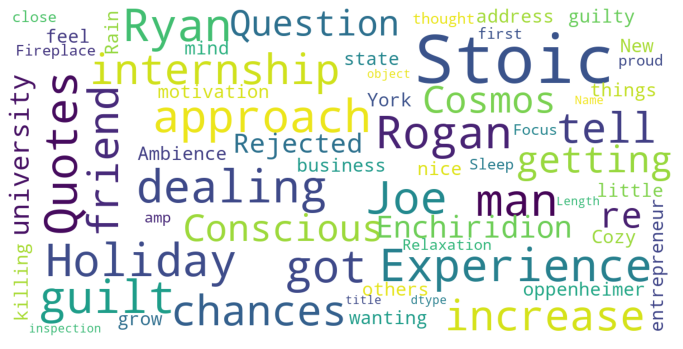

In [112]:
# word cloud for r/Stoicism
show_wordcloud(df1['title'])

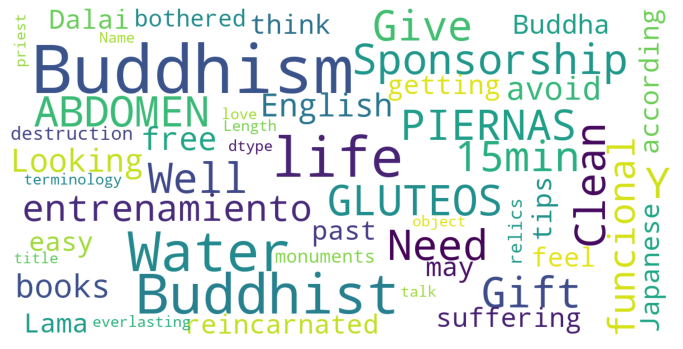

In [113]:
# word cloud for r/Buddhism
show_wordcloud(df2['title'])

Some observation can be made here - It is no surprise that `Stoic` and `Buddhism`/ `Buddhist` appears as the most mentioned word in their respective subreddit. We will explore other top most occuring words.

Curiously, words such as `Quotes`, `Ryan`, and `Experience` appears as the most frequent word in r/Stocism. Pairing these words with `stocism`, research shows that Ryan Holiday is an author of a popular book 'The Daily Stoic' which offers stocisim excercises and insights from many philosophers. Next, Joe Rogan is a podcaster has hosted subjects on stocism on his podcast titled 'The Joe Rogan Experience'.

In r/Buddhism, `Abdomen` is one of the key muscle groups in certain meditation poses and to acheive controlled breathing techniques. Buddhists believe that human life is a cycle of suffering and rebirth and could explain the keyword `life`. Similarly, `water` symbolises purity, clarity and calmness in buddhism. 

By looking at this the keywords, initial insights suggests that r/Stocisim focuses on the covering the content from 'The Daily Stoic' and the podcasts 'The Joe Rogan Experience'. It also seems that dealing with rejection or guilt may be part of the common topics.

In r/Buddism, the keywords suggest that meditation and the concept of life and suffering is frequently mentioned.

We are able to use this information to provide the relevant phrases or quotes to the User - for example, if the person has conflicted feelings he/she is dealing with, we may choose to provide excersises from the 'The Daily Stoic' to practice or be reflected on. Whereas if a person is feeling overwhelmed with life or seek to meditate or seek peacefulness, we may choose to provide relevant Buddhism phrases to the User.

https://spice.fsi.stanford.edu/docs/introduction_to_buddhism  
https://www.buddhanet.net/vmed_2.htm  
https://swedishwaterhouse.se/wp-content/uploads/The-significance-of-water-Buddhism_-ENG-and-SVE.pdf
 

### Top authors

In [114]:
def top_author(df):
    """
    Get the number and percentage of the post made by top 10 author in a subreddit
    """
    count = df['author'].value_counts().head(10)
    percent = round(df['author'].value_counts().head(10)/ len(df)*100,2)
    total = pd.concat([count, percent], axis=1,
                  keys=['count', 'percentage'])
    return total

In [115]:
# get the top 10 author in r/Stocism
top_author(df1)

,count,percentage
SolutionsCBT,82,0.84
Samuelhoffmann,55,0.56
alternatekicks87,51,0.52
pest_throwaw,49,0.50
[deleted],48,0.49
GD_WoTS,43,0.44
SecretChaosFolder,42,0.43
Kromulent,32,0.33
Itshardtofindanametf,31,0.32
envatted_love,28,0.29


In [116]:
# get top 10 author r/Buddism
top_author(df2)

,count,percentage
buddhadharmapractice,204,2.08
buddhadharmastudy,153,1.56
BuddhistFirst,132,1.35
Lethemyr,105,1.07
Rattedruide,100,1.02
kooka777,67,0.68
Old_Sick_Dead,65,0.66
SimonYap,52,0.53
Much_Walk1823,50,0.51
Jhana4,47,0.48


No significance is seen in `author`. The top authors in each subreddits only contributed a small percentage of the post. This indicates the posts are usually made by a different person or account. 

In [117]:
# Plot top 10 authors
# plt.figure(figsize=(8,5))
# ax = sns.countplot(y=df1['author'], order=df1['author'].value_counts().iloc[:10].index, palette='rocket')

In [118]:
# Plot top 10 authors 
# plt.figure(figsize=(8,5))
# ax = sns.countplot(y=df2['author'], order=df2['author'].value_counts().iloc[:10].index, palette='rocket')

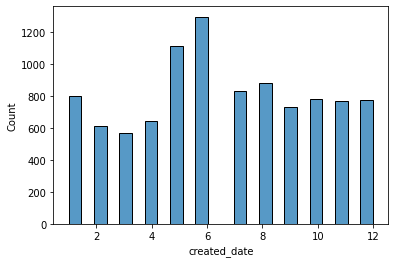

In [119]:
sns.histplot(df1['created_date'].dt.month);

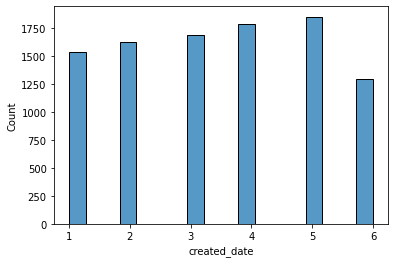

In [120]:
sns.histplot(df2['created_date'].dt.month);

In r/Stoicism, there is an increased in posts in the June period compared the the rest of the month. Initial research could not find any link between the month of June and stoicism.  
In r/Buddhism, the data collected suggests that posts only occured between Jan-June for the ~10,000 posts collected. It is unlikely this could happen because it has a sizable member. It is possible that the data extraction earlier could have went wrong. (To be looked into in the future).

Overall, no significance is found between the date posted between the subreddits

## Merging Dataframe 
---

After intial cleaning, both dataframe will be merged for further processing

In [122]:
# concat df from r/Stoicism and r/Buddhism
combined_df = pd.concat([df1, df2])

In [123]:
print(combined_df.shape)
combined_df.head(3)

(19615, 7)


,author,subreddit,title,selftext,created_utc,id,created_date
0,tylerdhenry,Stoicism,Joe Rogan Experience #1836 - Ryan Holiday,,1656003703,vj1nlr,2022-06-23 17:01:43
1,Kriispy66,Stoicism,Quotes from the man himself!,,1656003060,vj1etd,2022-06-23 16:51:00
2,Tristan6252,Stoicism,Stoic approach to dealing with guilt. I got an internship but didn't tell my friend to increase my chances of getting it.,"Recently, my friend and I were eagerly awaiting information regarding an internship opportunity from our lecturer in college. Upon receiving the details of the internship, we both seemed a little hesitant about applying and ultimately decided not to. If you don't get an internship for the next semester, you can do a certificate as a backup plan anyway, so we both weren't too concerned.\n\nHowever, on the final day to apply for the internship, I started to second-guess myself as I felt like I would be missing out on a huge opportunity to learn if I didn't at least try to get it. I also did a little more research into the job and it started to look more and more interesting the longer I looked into it, which I didn't mention to my friend. Ultimately, I decided to send in my CV and cover letter without notifying my friend and I got an email back to schedule an interview with the company which I did a few days later. Meanwhile, my friend doesn't know that I applied for the internship and thinks I'm doing the certificate with him because we both decided - on our own - that we just weren't interested in the jobs specifications.\n\nFast-forward a few more days and I end up getting the internship! I feel delighted to get it because I worked very hard throughout my course and I will put everything I can into this internship to make it worth my while and the companies time/resources. However, over the past few days, I've been feeling quite shameful and guilty because deep down, I know I didn't mention my application for the job to my friend because I knew that if he applied, there'd be a lower chance of me getting it. The more candidates, the less chance of winning, if that makes sense.\n\nI ended up telling him the truth a few days ago about the whole matter and deeply apologized to him for withholding information about the job and my application for it. He said that it was totally fine and that he would have probably done the same thing if he were in my shoes. He also mentioned that he just wasn't interested in the internship regardless. However, even him saying all this still doesn't allow my mind to rest. I feel incredible guilt over it and feel as though I don't deserve the internship because of it. \n\n\nThanks for reading all of this. I'd like to ask if any of you have some Stoic tips and insight to put my mind at ease?",1656000799,vj0jvj,2022-06-23 16:13:19


## Merging `title` and `selftext`
---

We wish to retain text from both columns, hence we will merge them into a column

In [124]:
# create a new column 'content' by merging title and selftext
combined_df['content'] = combined_df[['title', 'selftext']].apply(' '.join, axis=1)

In [125]:
# verify that collumn is created and merged
combined_df.sample(3)

,author,subreddit,title,selftext,created_utc,id,created_date,content
8908,kooka777,Buddhism,Defeating army of Mara,"Mendicants, I will teach you a path for crushing Māra’s army. Listen …\n\nAnd what is that path? It is the seven awakening factors. What seven? The awakening factors of mindfulness, investigation of principles, energy, rapture, tranquility, immersion, and equanimity. This is the path for crushing Māra’s army.”\n\n[source](https://suttacentral.net/sn46.43/en/sujato?layout=plain&amp;reference=none&amp;notes=asterisk&amp;highlight=false&amp;script=latin)",1643031392,sbmdit,2022-01-24 13:36:32,"Defeating army of Mara Mendicants, I will teach you a path for crushing Māra’s army. Listen …\n\nAnd what is that path? It is the seven awakening factors. What seven? The awakening factors of mindfulness, investigation of principles, energy, rapture, tranquility, immersion, and equanimity. This is the path for crushing Māra’s army.”\n\n[source](https://suttacentral.net/sn46.43/en/sujato?layout=plain&amp;reference=none&amp;notes=asterisk&amp;highlight=false&amp;script=latin)"
5978,Procariot,Stoicism,What do you think of misanthropy as a stoic?,"I've had an interest in stoicism for quite a time since I was born naturaly aphatic, it kinda suits me. And I have read about it.\n\nBut Im not sure if I could apply some things. And in this case would be the concept of Oikeiosis. I cannot treat strangers as family because I dont trust people.\n\nI dont hate others because Im incapable of feeling hate. Im not really sure if the feeling of hate really exists or its just hyperbole for disagreeing. I just dont expect anything from others and assume they are evil. And generally Im right so thats not changing.",1633807786,q4s7rs,2021-10-09 19:29:46,"What do you think of misanthropy as a stoic? I've had an interest in stoicism for quite a time since I was born naturaly aphatic, it kinda suits me. And I have read about it.\n\nBut Im not sure if I could apply some things. And in this case would be the concept of Oikeiosis. I cannot treat strangers as family because I dont trust people.\n\nI dont hate others because Im incapable of feeling hate. Im not really sure if the feeling of hate really exists or its just hyperbole for disagreeing. I just dont expect anything from others and assume they are evil. And generally Im right so thats not changing."
8560,Firelordozai87,Buddhism,How would our Zen brothers and sisters rate this quick run down of Zen?,,1643490563,sfrs3d,2022-01-29 21:09:23,How would our Zen brothers and sisters rate this quick run down of Zen?


In [126]:
# verify remaining columns
combined_df.columns

Index(['author', 'subreddit', 'title', 'selftext', 'created_utc', 'id',
       'created_date', 'content'],
      dtype='object')

`author`, `title`, `selftext`, `created_utc` and `id` can now be dropped

In [127]:
# drop columns
combined_df.drop(['author', 'title', 'selftext', 'created_utc', 'id'], axis=1, inplace=True)

In [128]:
# verify remaining columns
combined_df.sample(3)

,subreddit,created_date,content
6970,Buddhism,2022-02-26 10:06:10,Manifesting money
4007,Stoicism,2021-12-23 22:21:14,What is stoicisms’ perspective on any necessary evil? Question
8387,Stoicism,2021-07-11 12:17:37,"Stoic advice or mantras to deal with uncertain financial future I have decided I am going to drop my fulltime job to become a freelancer, things at work are rough, they found I am taking work on the side and are suspicious (even though our contract states I can do such)\nIts not good for my mental wellbeing, it's costing me my peace, but this post isnt about that.\n\nDo you have any texts or quotes I can ground myself with when during times of drought of work, I dont lose my edge and confidence for having no clients?\nI have work scheduled for the future but I want to prepare for a realistic view, that not everything may turn out roses, even though my business plan is solid in the big view of the year span."


## NLP Pre-Processing 
---

Since we are trying to train a model to identify between two possible responses - r/Stocisim and r/Buddhism, it is a binary classification and we will map the responses into 1 (r/Stoicism) and 0 (r/Buddhism). 

### Map categorical feature

In [129]:
# map response variable
combined_df['subreddit'] = combined_df['subreddit'].map({'Stoicism': 1, 'Buddhism':0})

In [130]:
# verify mapping is performed 
combined_df['subreddit'].unique()

array([1, 0], dtype=int64)

### Remove special characters, symbols

Before inserting the text in modelling, we will have to strip away any symbols, special characters or numbers. The following code attempts to do that

In [131]:
# apply regex function to clean text
combined_df['content'] = combined_df['content'].apply(clean_text)

In [132]:
# apply regex function to remove all emojis and symbols
combined_df['content'] = combined_df['content'].apply(remove_symbols)

In [133]:
# verify text is processed by looking at 5 random data
combined_df[['content']].sample(5)

,content
9453,questions about karma so i am hindu born into hindu family but i dont exactly understand the concepts of karma fullyi have been dealing with intense guilt and shame for past actions since the last months and desperate for reliefi did bad things i thought bad things and i said bad things in the pastbut now everytime i want to move forward with my life i think that i cant because this guilt is my karma that i deserve iti have irrational thoughts like if you get out of bed karma will come get you how do i deal with this im stuck in a cycle or self hatred and shame and guilt have therapist i speak to about this and i speak with my mother about it but nothing is workingso these are my questionshow do i deal with my fear of karmais harming yourself part of your karma and is it what i deserve or is it giving you bad karma for example if i was to do something bad and then hurt myself purposefully would that be instant karmaam i misunderstanding karma
8249,what is the best way to deal with people who criticize you or who are just critical in general i think this is a big one that buddism teaches whether its criticism that is directed at me or not i can just feel the bad energy naturally you get defensive but it doesnt make things better i hear stuff like be compassionate and dont react
4564,i recently came across a song i believe is rather stoic i would love to hear your thoughts on it i posted a while ago asking about the nature of relationships and detatchment as a stoic i was told that you can love people but must accept that it may not be forever and thats ok recently i came across this song see lyrics below and i interpret it to be about the fleeting nature of life and that it is more beautiful because its fleeting rather than forever id love to hear your thoughts on this lyrics we were born to bloomdestined to deteriorateno beauty in plastic flowersno honey made from fake bouquetswe were born to bloombut we were never meant to stayno wine from fruit made out of waxno honey made from fake bouquetswhat do they say about apples and treeshow do you grow when youre severed from the roots underneathand if the tether of love can never truly breakdid it slip from my hands the day you went awaywhy do they speak about a love that never diesand what the fuck do they know about the afterlifehave they ever spent the night screaming at the sky asking whywe were born to bloomdestined to deteriorateno beauty in plastic flowersno honey made from fake bouquetswe were born to bloombut we were never meant to stayno wine from fruit made out of waxno honey made from fake bouquetswhat do they say about the heart and its strengthwhat do you do when your love rots to into ragehow do you water the garden that famine takeshow do you feed your soul with dust and claywe blossom then wither like the rosedeath written into our blood like poemsa soliloquy of ancient ancestral painthe price of love paid over and over againwe were born to bloomdestined to deteriorateno beauty in plastic flowersno honey made from fake bouquetswe were born to bloombut we were never meant to stayno wine from fruit made out of waxno honey made from fake bouquetslove is watching the petals falllove is watching the petals falllove is watching the petals falllove is watching the petals fall
8316,apply stoicism from the previous post ive realized that we cant take everything stoics said as gospel and we shouldnt treat it as a religion but rather a guideline to base our actions on not something from which can get answers for every event in lifei want to know what are the lessons that you guys personally derived from this philosophy share with me
5582,things had never been this bad i am going through a tough time and i had never felt this low ever university seems too tough for me i dont know if ill even pass i may end up being a disappointment to my parents my girlfriend is now interested in another guy the breakup is just a matter of time im just avoiding whats inevitable i

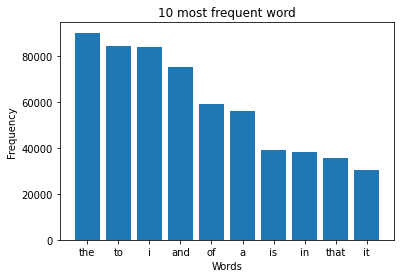

In [134]:
# examine the most popular word (without removing stopword)

description_list = combined_df['content'].values.tolist()

# Assign the counter instance 'most_common' call to a variable:
word_frequency = Counter(" ".join(description_list).split()).most_common(10)

# 'most_common' returns a list of (word, count) tuple
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

plt.bar(words, counts)
plt.title("10 most frequent word")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

The top occuring words consists of pro(nouns), adverbs and other non-descriptive words which will be removed because it is considered noise and does not contribute in understanding the key topics.

In [135]:
# make a copy of the dataframe before further processing
combined_df_processed = combined_df.copy()

### Tokenize text 

Word tokenization is the process of splitting large text into smaller chunks called 'tokens'. These tokens help to model to understand the context of the words.

In [136]:
col_to_tokenize = ['content']

In [137]:
# Define a function to clean text data (remove whitespace, 
# keep only alphabet characters & make lowercase)

def tokenize_data(data, col_list):
    tokenizer = RegexpTokenizer(r'\w+')
    for col in col_list:
        tokenized_items = [tokenizer.tokenize(item.lower()) for item in data[col]]
        data[f'tokenized_{col}'] = tokenized_items
    return data  

In [138]:
# tokenize content
combined_df_processed = tokenize_data(combined_df_processed, col_to_tokenize)

In [139]:
combined_df_processed.sample(5)

,subreddit,created_date,content,tokenized_content
8723,0,2022-01-27 07:03:27,how to not be afraid of death is there a certain reference to buddhas teachings that might be helpful tia,"[how, to, not, be, afraid, of, death, is, there, a, certain, reference, to, buddhas, teachings, that, might, be, helpful, tia]"
3515,1,2022-01-10 17:41:00,epictetus seneca amp marcus aurelius the best translations trying to figure out the best translations to buy of their work any recommendationsthanks,"[epictetus, seneca, amp, marcus, aurelius, the, best, translations, trying, to, figure, out, the, best, translations, to, buy, of, their, work, any, recommendationsthanks]"
8908,1,2021-06-21 23:55:21,are you glad pewdiepie promoted stoicism or do you regret that it brings his audience of year olds into your domain,"[are, you, glad, pewdiepie, promoted, stoicism, or, do, you, regret, that, it, brings, his, audience, of, year, olds, into, your, domain]"
3072,0,2022-05-03 12:54:51,buddhist reason for believing in reincarnation,"[buddhist, reason, for, believing, in, reincarnation]"
6736,1,2021-09-06 20:29:50,has anyone else had perfect stoic moments so what i mean by this is has anything ever happened to you that under usual circumstances would have made you have a negative reaction but this time you didnt so you werent hurt because you truly didnt believe you were and you just let it go and continued to move or first example is about years again i used to be friends with a guy i had know since high school we were kinda like family and so wed always have disagreements and not talk for a while because he is extremely self centered and jealous among other things people have called him i was separating from my exwife and he live in the middle of the next state over he and i had been on good terms again for a about a year or maybe longer at this point i being the only one with a reliable income and my exwife leaving me to keep the apartment and take care of our childs expensenses and child care alone it became too much to handle and trying to take care of my daughter over everything else i got evicted he convinced me to move out to his state with him he was setting me up with a job at the same company he worked for all i had to do was show up save money and then we were going to be moving into a bigger place he and his girlfriend lived in a nice sized one bedroom so i was on the couch i spent all of the money i had to get to the state and had enough for a little bit of food and to keep gas in the truck i had at the time i had passed the background check drug test and physical for the job and just had to wait for start datewe both have martial arts backgrounds and he had started a a child i started training after high school when i was finally able to afford it the joke among the people who knew us was that he was talent and i was hard work i pretty much ate lived and slept martial arts when i started it and literally took advice from everyone of any style because i believed i could learn from everyone and everything i ended up becoming an amatuer champion kickboxer and mixed martial artist he although talented talked big and never trained as hard or as dedicated as i didso a day before i start working which i loved the job for the weeks i was there lol we met up with one of his local friends who had a background in boxing im going to call my former friend den so it gets easy to keep track of people den wanted to do some martial arts training and teach the boxer some of the stuff he knew i knew more but i wasnt the type to brag or show off but this particular day although it wasnt my intent to show off when he was trying to show th friend a move that was ineffective and didnt really work the way he was trying to make it out to since he told me i was wrong when i said that it wouldnt instead of arguing i just decided to let actions speak louder than words and countered his technique he then tried to counter with another ineffective technique which again go

### Lemmatizing

Lemmatizing is used (instead of stemming) because it preserves the meaning of the word better. The downside is a longer computation time but the number of data in this case in relatively small so we will choose accuracy (of the word) over saving computation time.  
https://analyticsindiamag.com/explained-stemming-vs-lemmatization-in-nlp/

In [140]:
# instantiate Lemmatizer
lemmatizer = WordNetLemmatizer()

In [141]:
col_to_lem = ['tokenized_content']

In [142]:
def lemmatize_data(data, col_list):
    for col in col_list:
        lemmed_items = []
        for row in data[col]:
            lemmed_row = [lemmatizer.lemmatize(word) for word in row]
            lemmed_items.append(lemmed_row)
        data[f'lem_{col}'] = lemmed_items
    return data 

In [143]:
# lemmatize tokenized_content
combined_df_processed = lemmatize_data(combined_df_processed, col_to_lem)

In [144]:
combined_df_processed.sample(3)

,subreddit,created_date,content,tokenized_content,lem_tokenized_content
8749,1,2021-06-27 18:07:28,book recommendation at the existentialist cafe by sarah bakewell i have been seeking ways to grow as a stoic and by doing so have been seeking to learn more about other philosophies that place emphasis on offering a way to actually live life as opposed to merely thinking about the world while not all philosophy need be useful in that it creates a way for a follower to live i am a stoic because i truly believe that it has helped me increase my resilience rise above my traumatic circumstances and manage negative feelings like grief and anxiety sarah bakewell put that into words wonderfully in at the existentialist cafe in this pursuit ive been reading a lot on existentialism this post shares some of the thoughts spurred from these readings with a favorite of the readings being at the existentialist cafe that book specifically acted as a springboard for inspiration into other texts and the desire to learn more about other philosophies in a way that uses stoicism as a constant comparison point that constant comparison strengthened my approach to living stoically so why read about existentialism in my head and as illustrated by sarah bakewell existentialism shares much common thought with stoicism in that stoicism along with phenomenological and epicurean philosophy influenced a lot of modern existentialism i see them existing almost as a venn diagram and ive enjoyed reflecting on what is similar vs different largely due to the intriguing writing of sarah bakewell one of the main differences in this venn diagram of existentialism and stoicism seems to be values and virtue with stoicism there are the main virtues of fortitude justice temperance and prudence and to practice these while also seeking to recognize what is and isnt under our control to me the goal is to not be defined as a virtuous person but to live virtuously it is not the pursuit of the label but accepting that a label has been put on you and choosing to control what you can and separate emotions from what you cannot stoicism recognizes that sometimes what we want cant be achieved through our actions that really the only control we have is over our perception by mastering our attitudes and recognizing what is perception vs what is actual we can control our emotions in a way as to find contentment there is virtue in that pursuit of controlexistentialism on the hand often puts the responsibility on the individual to reject all labels and define themselves solely from their actions from there out their choices are seen as actions defining their authenticity and to not act is to not be authentic the only virtue really then is the active pursuit of authenticity or in other words acceptance of ones free choice as the sole way to define themselves one is not static then or centering around a single point or school of virtue but instead constantly reforming and reshaping based on a string of choices unlike stoicism there is no string of virtue to shape this path but pure freedom the individ...,"[book, recommendation, at, the, existentialist, cafe, by, sarah, bakewell, i, have, been, seeking, ways, to, grow, as, a, stoic, and, by, doing, so, have, been, seeking, to, learn, more, about, other, philosophies, that, place, emphasis, on, offering, a, way, to, actually, live, life, as, opposed, to, merely, thinking, about, the, world, while, not, all, philosophy, need, be, useful, in, that, it, creates, a, way, for, a, follower, to, live, i, am, a, stoic, because, i, truly, believe, that, it, has, helped, me, increase, my, resilience, rise, above, my, traumatic, circumstances, and, manage, negative, feelings, like, grief, and, anxiety, sarah, bakewell, ...]","[book, recommendation, at, the, existentialist, cafe, by, sarah, bakewell, i, have, been, seeking, way, to, grow, a, a, stoic, and, by, doing, so, have, been, seeking, to, learn, more, about, other, philosophy, that, place, emphas

## Save to CSV

In [ ]:
combined_df_processed.to_csv('../data/df_final.csv', index=False)